# Training feature selection and Random Forest classifier training

## Background

This notebook focuses on training a Random Forest classifier for wetland mapping and classification using Earth Observation (EO) measurements. Before fitting the classifier, the notebook removes highly correlated features, aiming to optimize the model's performance. Furthermore, it evaluates the model's performance using a confusion matrix, providing insights into the classification accuracy for different wetland classes. By incorporating these steps, the notebook aims to enhance the accuracy, interpretability, and reliability of the Random Forest classifier in mapping and classifying wetlands.

## Fit and evaluate a Random Forest classifier

We use the [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) implemented in the [`scikit-learn`](https://scikit-learn.org/stable/) Python libary to map wetland types. 

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. 

A number of hyperparameters can be tuned for this classifier and we will use funtionalities provided by the [`scikit-learn`](https://scikit-learn.org/stable/) libary to tune and evaluate the model.

This notebook demonstrates how to fit, tune and evaluate the crop type classification model. We will use the subset of training features balanced and selected earlier in the notebook.

### Load necessary packages

In [1]:
%matplotlib inline
import os
import json
import datacube
import warnings
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.metrics import accuracy_score,cohen_kappa_score,confusion_matrix,ConfusionMatrixDisplay,balanced_accuracy_score
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score
from joblib import dump

### Load sampled training data
We will load the training data saved from the [feature extraction notebook](03_Feature_Extraction.ipynb).

In [2]:
# Specify a prefix to identify the area of interest in the saved outputs
# By assigning the desired prefix, you can easily identify the outputs associated with the specific area of interest.
prefix = 'Rwanda'

training_features = gpd.read_file(f'results/{prefix}_training_features.geojson')
training_features.head()  # Plot first five rows

field = "class_id"

Remove unnecessary columns e.g. coordinates and geometry attributes and remove samples with NaN values which were 0 after geomedian calculation:

In [3]:
# drop columns not for analysis
df_training_data=training_features.iloc[:,:-3]
# remove invalid values
# df_training_data=df_training_data.loc[(df_training_data!=0).all(axis=1)].reset_index(drop=True) 
print('Number of features: ',len(df_training_data.columns))
df_training_data.head()

Number of features:  32


,class_id,blue_0,green_0,red_0,red_edge_1_0,red_edge_2_0,red_edge_3_0,nir_1_0,nir_2_0,swir_1_0,...,Rwanda_mrrtf,Rwanda_mrvbf,Rwanda_slope,Rwanda_TWI,Rwanda_elevation,Rwanda_curvature,vv,vh,vh/vv,WOfS_annual_frequency
0,3.0,380.0,497.0,383.0,458.0,298.0,302.0,248.0,245.0,164.0,...,0.0,4.0,0.000000,4.605170,1327.000000,0.000000,0.007559,0.001226,0.155514,0.961538
1,4.0,287.0,326.0,318.0,314.0,195.0,203.0,174.0,166.0,198.0,...,2.0,6.0,6.009252,3.546794,1284.500000,-103.002930,0.006244,0.001500,0.244431,0.894737
2,3.0,408.0,526.0,497.0,591.0,841.0,961.0,628.0,1014.0,584.0,...,1.0,6.0,0.000000,5.703783,1283.000000,-109.863281,0.021349,0.006624,0.289174,0.000000
3,1.0,362.0,624.0,518.0,941.0,1919.0,2294.0,2634.0,2555.0,1406.0,...,0.0,2.0,4.166667,4.888613,1287.000000,-406.652832,0.103264,0.026145,0.282120,0.000000
4,0.0,534.0,700.0,739.0,1181.0,2119.0,2425.0,2557.0,2617.0,2094.0,...,0.0,0.0,13.869431,3.150794,1704.448975,1839.453125,0.145716,0.031686,0.190575,0.000000


### Check for feature correlation 

When it comes to training feature selection, our approach involved extracting a wide range of Earth Observation (EO) measurements that had the potential to contribute to the mapping and classification of wetlands. However, it is important to address the issue of correlated measurements, where certain features describe similar or related properties of wetlands. Including highly correlated features in a model can increase its complexity without necessarily improving prediction performance. To mitigate this, it is considered good practice to remove highly correlated features. By doing so, we reduce the complexity of the model while maintaining or even enhancing its prediction capabilities.


To inspect the feature correlations, we will split the data into features and labels.

In [4]:
# split into features and labels
X = df_training_data.drop(field, axis=1).values
y = df_training_data[[field]].values.ravel()

#### Create and visualize the correlation_matrix

The correlations can be visualized in a color-coded table. The coefficient values range from 0 to 1, with 0 for no corelation and 1 for perfect correlation. The diagonal elements are always 1.

In [5]:
X_ = df_training_data.drop(field, axis=1)
correlation_matrix = X_.corr().abs()

# plot correlation matrix
correlation_matrix.style.background_gradient(cmap='coolwarm').format(precision=2)

,blue_0,green_0,red_0,red_edge_1_0,red_edge_2_0,red_edge_3_0,nir_1_0,nir_2_0,swir_1_0,swir_2_0,emad_0,smad_0,bcmad_0,NDVI_0,MNDWI_0,TCW_0,Rwanda_hillshade,Rwanda_profile_curvature,Rwanda_TPI,Rwanda_aspect,Rwanda_planform_curvature,Rwanda_mrrtf,Rwanda_mrvbf,Rwanda_slope,Rwanda_TWI,Rwanda_elevation,Rwanda_curvature,vv,vh,vh/vv,WOfS_annual_frequency
blue_0,1.00,0.94,0.90,0.75,0.25,0.20,0.18,0.15,0.36,0.50,0.45,0.03,0.07,0.08,0.03,0.29,0.19,0.02,0.00,0.17,0.02,0.01,0.27,0.20,0.27,0.35,0.00,0.25,0.17,0.27,0.14
green_0,0.94,1.00,0.94,0.88,0.42,0.36,0.34,0.31,0.45,0.54,0.53,0.12,0.17,0.07,0.14,0.33,0.20,0.03,0.09,0.18,0.03,0.01,0.29,0.22,0.27,0.29,0.04,0.29,0.23,0.22,0.26
red_0,0.90,0.94,1.00,0.87,0.34,0.28,0.25,0.22,0.43,0.55,0.46,0.12,0.17,0.03,0.11,0.34,0.18,0.04,0.10,0.17,0.01,0.03,0.32,0.26,0.29,0.21,0.04,0.25,0.17,0.30,0.21
red_edge_1_0,0.75,0.88,0.87,1.00,0.72,0.67,0.65,0.63,0.73,0.76,0.56,0.33,0.47,0.42,0.50,0.61,0.26,0.05,0.06,0.22,0.04,0.02,0.45,0.39,0.37,0.21,0.02,0.48,0.48,0.12,0.59
red_edge_2_0,0.25,0.42,0.34,0.72,1.00,1.00,0.99,0.99,0.89,0.78,0.37,0.60,0.78,0.90,0.90,0.78,0.28,0.01,0.07,0.24,0.06,0.10,0.44,0.43,0.34,0.05,0.02,0.64,0.77,0.24,0.92
red_edge_3_0,0.20,0.36,0.28,0.67,1.00,1.00,1.00,1.00,0.87,0.75,0.35,0.60,0.79,0.93,0.90,0.77,0.27,0.01,0.07,0.24,0.05,0.12,0.41,0.41,0.32,0.03,0.02,0.63,0.78,0.28,0.92
nir_1_0,0.18,0.34,0.25,0.65,0.99,1.00,1.00,1.00,0.87,0.75,0.33,0.60,0.79,0.93,0.91,0.77,0.26,0.01,0.10,0.24,0.05,0.12,0.41,0.40,0.31,0.04,0.02,0.63,0.78,0.29,0.92
nir_2_0,0.15,0.31,0.22,0.63,0.99,1.00,1.00,1.00,0.88,0.75,0.32,0.60,0.80,0.94,0.92,0.78,0.26,0.00,0.10,0.23,0.07,0.12,0.41,0.41,0.31,0.03,0.03,0.62,0.78,0.32,0.93
swir_1_0,0.36,0.45,0.43,0.73,0.89,0.87,0.87,0.88,1.00,0.97,0.40,0.50,0.72,0.77,0.90,0.97,0.28,0.10,0.23,0.27,0.13,0.01,0.58,0.51,0.41,0.12,0.13,0.65,0.74,0.17,0.89
swir_2_0,0.50,0.54,0.55,0.76,0.78,0.75,0.75,0.75,0.97,1.00,0.42,0.41,0.62,0.61,0.79,0.97,0.28,0.11,0.26,0.27,0.10,0.03,0.59,0.49,0.41,0.16,0.12,0.64,0.69,0.05,0.78


### Remove correlated features.
We will define a function and set a threshold of 0.9 to remove correlated features.

In [6]:
removal_threshold = 0.9

# function for removing correlated variables
def DropCorrelatedFeatures(X_, removal_threshold=0.9):
    to_drop = set()  # set of features to drop
    correlation_matrix = X_.corr().abs()
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if (correlation_matrix.iloc[i, j] >= removal_threshold) and (correlation_matrix.columns[j] not in to_drop):
                colname = correlation_matrix.columns[i]
                to_drop.add(colname)
    to_drop = list(to_drop)
    X_dropped = X_.copy()
    X_dropped = X_dropped.drop(to_drop, axis=1)
    return X_dropped

In [7]:
X_ = df_training_data.drop(field, axis=1)
X_dropped = DropCorrelatedFeatures(X_, removal_threshold=removal_threshold)
print("# of features kept:", len(X_dropped.columns))

# of features kept: 20


In [8]:
# df_training_data = pd.concat([df_training_data[field], X_dropped], axis = 1)

## Grid search for optimal hyperparameters

A number of hyperparameters can be tuned to optimize the performance of a random forest algorithm. These parameters specifiy how many decision trees are used, when and how data are split into nodes, how many samples and features are used when looking for the best split, and so on. A complete list of parameters and their explanations can be found in the [library documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier).

In our example, we perform a grid search of the following four hyperparameters:

* `class_weight`: Weights associated with classes. If not given, all classes are supposed to have weight one. The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as `n_samples / (n_classes * np.bincount(y))`.
* `max_features`: The number of features to consider when looking for the best split. If “sqrt”, then `max_features=sqrt(n_features)`. If “log2”, then `max_features=log2(n_features)`. If None, then `max_features=n_features`.
* `n_estimators`: The number of trees in the forest.
* `criterion`: The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “log_loss” and “entropy” both for the Shannon information gain, see [Mathematical formulation](https://scikit-learn.org/stable/modules/tree.html#tree-mathematical-formulation).\

> Searching over a large grid takes time. For testing, the search can be applied on a subset of parameter options.

In [9]:
# Create the parameter grid based on the results of random search 
grid_parameters={'n_estimators': [int(x) for x in np.linspace(start = 50, stop = 100, num = 2)],
                 'max_features': ['sqrt', 'log2']}

In [10]:
# initialise a random forest classifier
rf = RandomForestClassifier()

# stratified K-fold splitting strategy for grid search
cv=model_selection.StratifiedKFold(n_splits=5,shuffle=True,random_state=0) 

# grid search to find optimal random forest classifier hyperparameters
print('Grid searching best hyper-parameters...')
grid_search=model_selection.GridSearchCV(estimator = rf,param_grid=grid_parameters,cv=cv,n_jobs=-1)

#convert variable names into sci-kit learn nomenclature
X = df_training_data.to_numpy()[:,1:]
y = df_training_data.to_numpy()[:,0]

# fit to all the data
grid_search.fit(X,y)
print('Optimal parameters: \n',grid_search.best_params_)

Grid searching best hyper-parameters...
Optimal parameters: 
 {'max_features': 'log2', 'n_estimators': 50}


### Fit a classifier with selected hyperparameters

In [11]:
rf = RandomForestClassifier(**grid_search.best_params_, random_state=1, n_jobs=-1)
rf.fit(X,y)

RandomForestClassifier(max_features='log2', n_estimators=50, n_jobs=-1,
                       random_state=1)

### Examine feature importance

Feature importance shows which features have the largest effect on the model prediction. We will explore the top 10 most important features and visualize the importance of all features.

Text(0, 0.5, 'Importance')

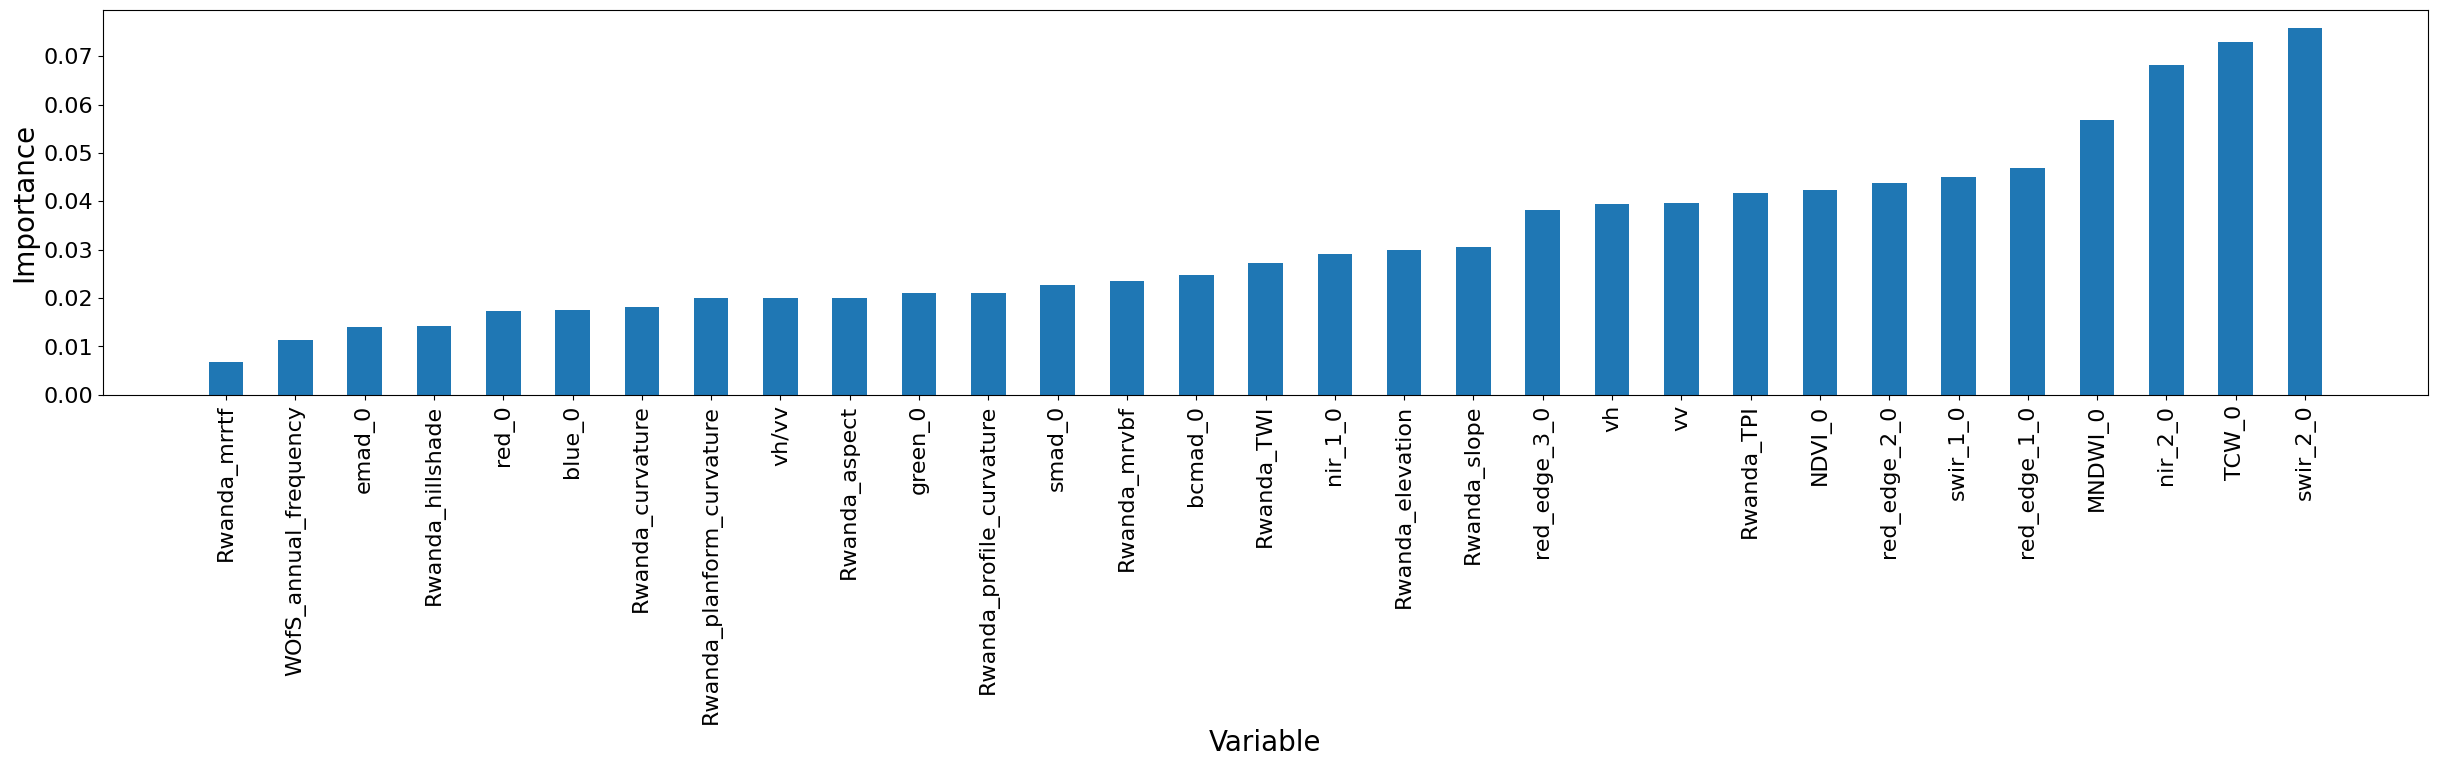

In [12]:
# plot feature importance
plt.figure(figsize=(30,5))
order=np.argsort(rf.feature_importances_)
plt.bar(x=np.array(df_training_data.columns[1:])[order],height=rf.feature_importances_[order],width=0.5,align='center')
plt.xticks(rotation='vertical',fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Variable', fontsize=20)
plt.ylabel('Importance', fontsize=20)

## Accuracy assessment

Finally we use a 5-fold cross validation to estimate the performance of the model. While the cross validation evaluates the predictive power of our model on unseen data, the result may not generalize for input data that have distinct spectral and temporal signatures to the training dataset. 

We will inspect four performance metrics:

* Overall accuracy
* Precision for each class - fraction of positive predictions that are correct. $precision = N_{True Positive}/(N_{True Positive} + N_{False Positive})$. The best value is 1 and the worst value is 0.
* Recall for each class - ability of the classifier to find all the positive samples. $recall = N_{True Positive}/(N_{True Positive} + N_{False Negative})$. The best value is 1 and the worst value is 0.
* F1 macro - averaged F1 scores for all classes. For each class, $F1 = 2*(precision*recall)/(precision+recall)$


In [13]:
#import the class label dictionary which stores the mapping between class IDs and class names in a structured format. 
with open(f'{prefix}_labels_dict.json', 'r') as json_file:
    labels_dict = json.load(json_file)

# Print the loaded label dictionary
print(labels_dict)

{'Dam': 2, 'Lake': 3, 'Open water': 4, 'Marsh': 1, 'Large river': 5, 'Non-wetland': 0}


In [14]:
#Stratified k-fold splitting
skf=model_selection.StratifiedKFold(n_splits=5,shuffle=True,random_state=1) 

# calculate overall accurcy through cross validation
overall_acc=model_selection.cross_val_score(rf,X,y,cv=skf,scoring='accuracy')
print('Overall accuracy from cross validation: ',np.mean(overall_acc))

Overall accuracy from cross validation:  0.7779623477297896


In [15]:
values = list(labels_dict.values())
predictions = model_selection.cross_val_predict(rf, X, y, cv=skf)
precision = precision_score(y, predictions, labels=values, average=None)
print('Precision for each class: \n', dict(
    zip([key for key in labels_dict.keys()], np.around(precision, 3))))

Precision for each class: 
 {'Dam': 0.5, 'Lake': 0.773, 'Open water': 0.0, 'Marsh': 0.745, 'Large river': 0.571, 'Non-wetland': 0.838}


In [16]:
recall = recall_score(y, predictions, labels=values, average=None)
print('Recall for each class: \n', dict(
    zip([key for key in labels_dict.keys()], np.around(recall, 3))))

Recall for each class: 
 {'Dam': 0.125, 'Lake': 0.935, 'Open water': 0.0, 'Marsh': 0.778, 'Large river': 0.444, 'Non-wetland': 0.918}


In [17]:
f1_macro = model_selection.cross_val_score(
    rf, X, y, cv=skf, scoring='f1_macro')
print('f1_macro from cv scores: ', np.mean(f1_macro))

f1_macro from cv scores:  0.5187349570803081


### Plot confusion matrix

The confusion matrix compares all predictions against the labels and allow us to see what types of prediction errors the model is making.  

Confusion matrix:



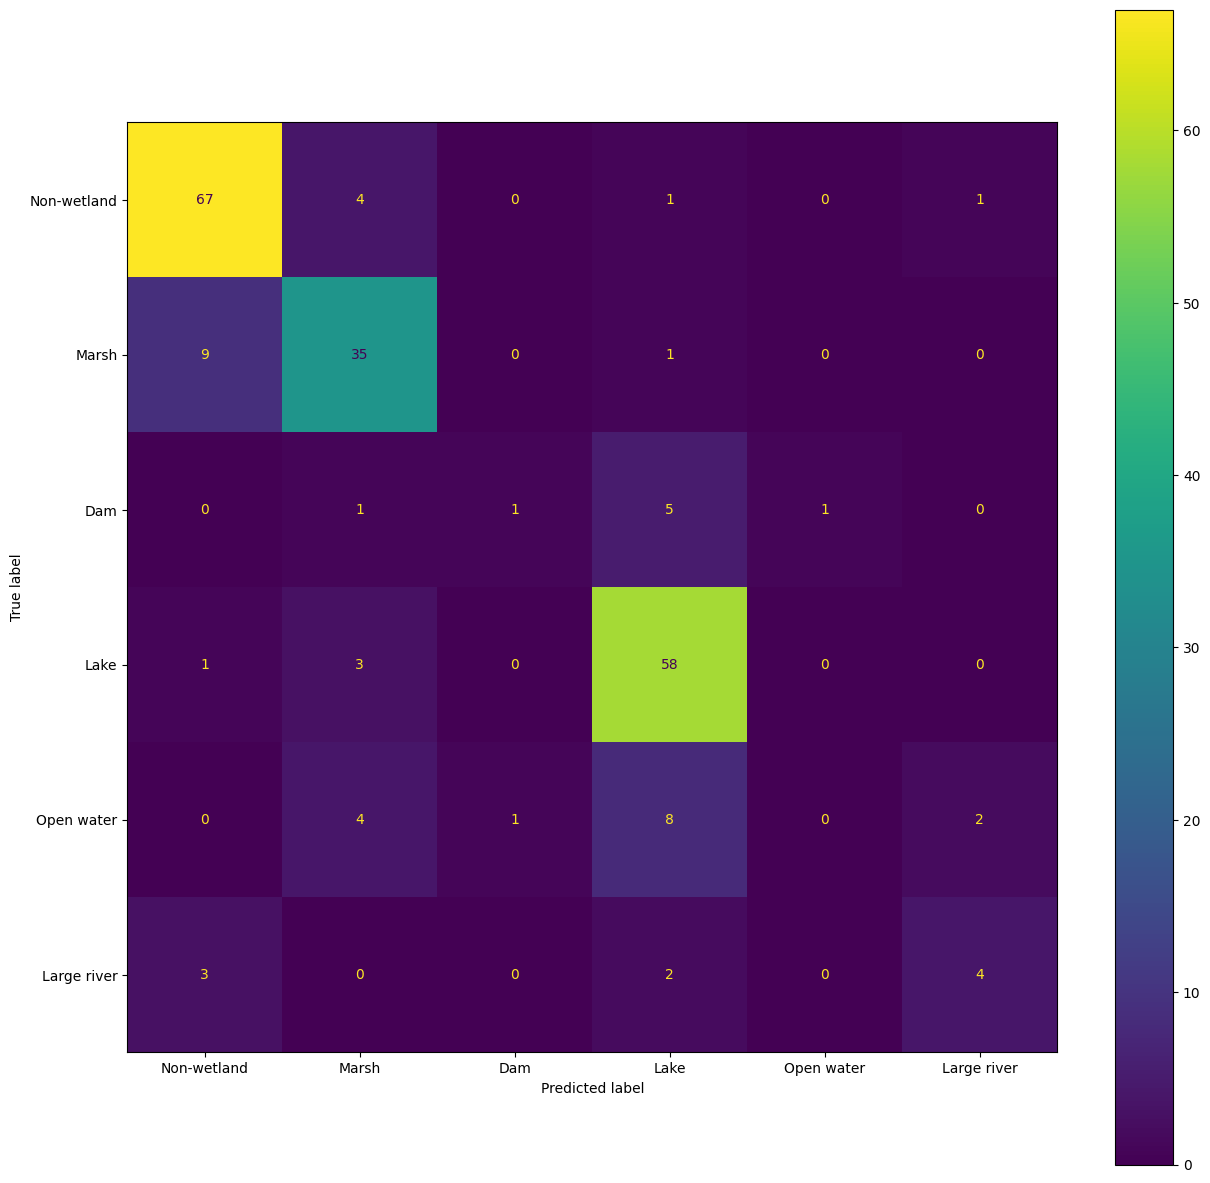

In [18]:
cm = confusion_matrix(y, predictions)
display_labels = [list(labels_dict.keys())[list(
    labels_dict.values()).index(i)] for i in rf.classes_]
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=display_labels)
print('Confusion matrix:\n')
fig, ax = plt.subplots(figsize=(15, 15))
disp.plot(ax=ax)

## Save the model

In [19]:
dump(rf, f'results/{prefix}_RF_model.joblib')

['results/Rwanda_RF_model.joblib']

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [20]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2023-07-07'